In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_absolute_error, mean_squared_error
from math import sqrt
from prophet import Prophet

d:\Project\Project\Intern_Intelligence\Time-Series-Forecasting\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Importing plotly failed. Interactive plots will not work.


In [2]:
data_url = 'https://raw.githubusercontent.com/jbrownlee/Datasets/master/airline-passengers.csv'
data = pd.read_csv(data_url, parse_dates=['Month'], index_col='Month')
print(data.head())

            Passengers
Month                 
1949-01-01         112
1949-02-01         118
1949-03-01         132
1949-04-01         129
1949-05-01         121


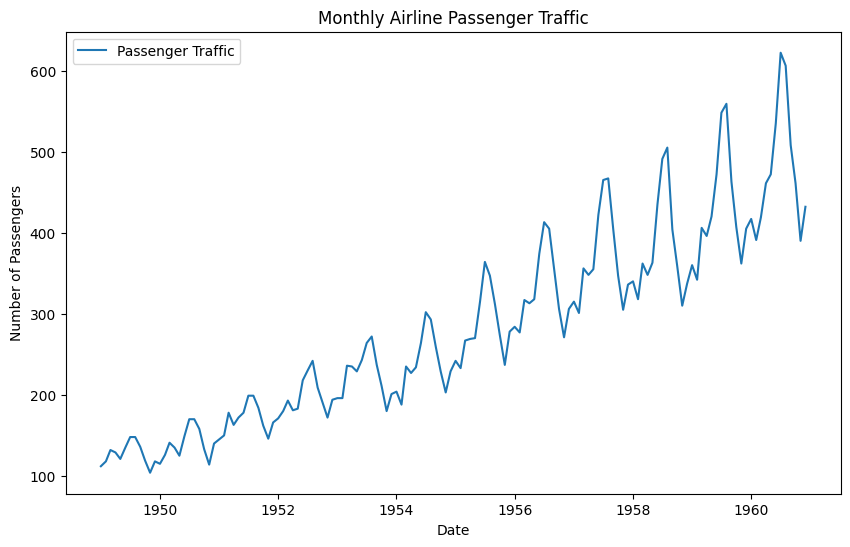

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(data, label='Passenger Traffic')
plt.title('Monthly Airline Passenger Traffic')
plt.xlabel('Date')
plt.ylabel('Number of Passengers')
plt.legend()
plt.show()

## Pre-Processing and Stationarity Check  
- Time series models like ARIMA often require the data to be stationary.    
- We’ll perform an Augmented Dickey-Fuller (ADF) test to check for stationarity and difference the data if necessary.